In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import mutual_info_regression

import warnings
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv("data_input/train.csv")
test=pd.read_csv("data_input/test.csv")

In [3]:
train.shape, test.shape

((3000, 23), (4398, 22))

In [4]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [5]:
train.tail(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
2999,3000,NaN,35000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",http://www.abductionthefilm.com/,tt1600195,en,Abduction,A young man sets out to uncover the truth abou...,10.512109,...,9/22/11,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They stole his life. He's taking it back.,Abduction,"[{'id': 591, 'name': 'cia'}, {'id': 822, 'name...","[{'cast_id': 2, 'character': 'Nathan Harper', ...","[{'credit_id': '5391990d0e0a260fb5001629', 'de...",82087155


## feature engineering
- selecting cols for my part: crew, cast, production_companies, production_countries, status

In [6]:
train = train[['crew', 'cast', 'production_companies', 'production_countries', 'status', 'revenue']]
test = test[['crew', 'cast', 'production_companies', 'production_countries', 'status']]

In [7]:
train.head(1)

,crew,cast,production_companies,production_countries,status,revenue
0,"[{'credit_id': '59ac067c92514107af02c8c8', 'de...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",Released,12314651


### crew

In [8]:
for i, e in enumerate(train[4:6]['crew']):
  for j, k in enumerate(eval(e)):
    print(k)

{'credit_id': '52fe464b9251416c75073b43', 'department': 'Directing', 'gender': 0, 'id': 84749, 'job': 'Director', 'name': 'Jong-seok Yoon', 'profile_path': None}
{'credit_id': '52fe464b9251416c75073b55', 'department': 'Writing', 'gender': 0, 'id': 84749, 'job': 'Writer', 'name': 'Jong-seok Yoon', 'profile_path': None}
{'credit_id': '52fe46f49251416c9106558b', 'department': 'Writing', 'gender': 2, 'id': 67372, 'job': 'Novel', 'name': 'Collodi', 'profile_path': '/sMMNkbghC5alRHZEblJA0T4c9uO.jpg'}
{'credit_id': '52fe46f49251416c91065573', 'department': 'Directing', 'gender': 2, 'id': 176063, 'job': 'Director', 'name': 'Hal Sutherland', 'profile_path': None}
{'credit_id': '52fe46f49251416c91065585', 'department': 'Writing', 'gender': 0, 'id': 193849, 'job': 'Screenplay', 'name': "Dennis O'Flaherty", 'profile_path': None}
{'credit_id': '5345adea0e0a265ff8000075', 'department': 'Writing', 'gender': 0, 'id': 1213367, 'job': 'Teleplay', 'name': "Barry O'Brien", 'profile_path': '/7zl5GGMrLpEFLV

In [9]:
train['crew_count'] = train['crew'].map(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)
test['crew_count'] = test['crew'].map(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)

----- crew_count VS revenue -----
linear correlation: 0.37211003598893544
mutual dependency: 0.11068734357368726


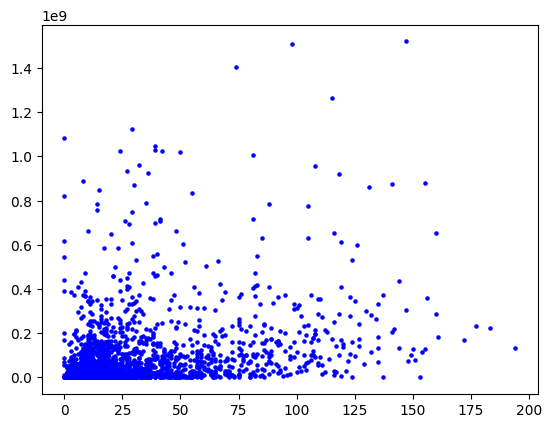

In [10]:
print('----- crew_count VS revenue -----')
print('linear correlation:', train['crew_count'].corr(train['revenue']))
print('mutual dependency:', mutual_info_regression(train[['crew_count']], train['revenue'])[0])
plt.scatter(train['crew_count'], train['revenue'], color='blue', s=5)

In [11]:
train["crew_name_job"] = train["crew"].map(lambda x: [f'crew_{crew["job"]}_{crew["name"]}' for crew in ast.literal_eval(x)] if pd.notna(x) else [])
test["crew_name_job"] = test["crew"].map(lambda x: [f'crew_{crew["job"]}_{crew["name"]}' for crew in ast.literal_eval(x)] if pd.notna(x) else [])

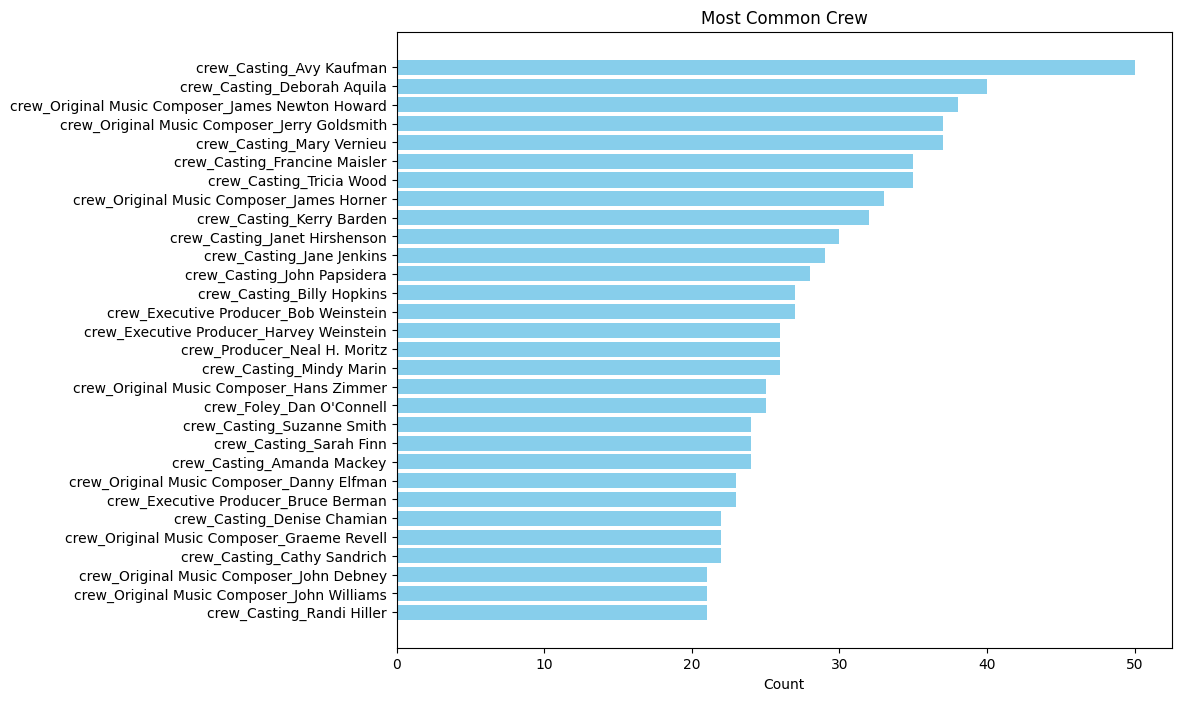

In [12]:
train_crew_names = [crew for crew_list in train["crew_name_job"] for crew in crew_list]

train_name_counts = Counter(train_crew_names)

popular_name_job = train_name_counts.most_common(30)
names, name_counts = zip(*popular_name_job)

plt.figure(figsize=(10, 8))
plt.barh(names, name_counts, color='skyblue')
plt.xlabel('Count')
plt.title('Most Common Crew')
plt.gca().invert_yaxis()
plt.show()

In [13]:
train_crew_names = [crew for crew_list in train["crew_name_job"] for crew in crew_list]
train_name_counts = Counter(train_crew_names)
top_30_crew_name_jobs = [name for name, count in train_name_counts.most_common(30)]

train["crew_name_job_filtered"] = train["crew_name_job"].apply(lambda x: [crew for crew in x if crew in top_30_crew_name_jobs])
test["crew_name_job_filtered"] = test["crew_name_job"].apply(lambda x: [crew for crew in x if crew in top_30_crew_name_jobs])

mlb = MultiLabelBinarizer(classes=top_30_crew_name_jobs)

train_crew_encoded = mlb.fit_transform(train["crew_name_job_filtered"])
test_crew_encoded = mlb.transform(test["crew_name_job_filtered"])

train_crew_encoded_df = pd.DataFrame(train_crew_encoded, columns=mlb.classes_)
test_crew_encoded_df = pd.DataFrame(test_crew_encoded, columns=mlb.classes_)

train = pd.concat([train, train_crew_encoded_df], axis=1)
test = pd.concat([test, test_crew_encoded_df], axis=1)

train.drop(columns=["crew_name_job", "crew_name_job_filtered"], inplace=True)
test.drop(columns=["crew_name_job", "crew_name_job_filtered"], inplace=True)

In [14]:
train['genders_0_crew'] = train['crew'].map(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 0]) if pd.notna(x) else 0)
train['genders_1_crew'] = train['crew'].map(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 1]) if pd.notna(x) else 0)
train['genders_2_crew'] = train['crew'].map(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 2]) if pd.notna(x) else 0)

test['genders_0_crew'] = test['crew'].map(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 0]) if pd.notna(x) else 0)
test['genders_1_crew'] = test['crew'].map(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 1]) if pd.notna(x) else 0)
test['genders_2_crew'] = test['crew'].map(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 2]) if pd.notna(x) else 0)

In [15]:
train.drop(columns=['crew'], inplace=True)
test.drop(columns=['crew'], inplace=True)

### cast

In [16]:
for i, e in enumerate(train[4:6]['cast']):
  for j, k in enumerate(eval(e)):
    print(k)

{'cast_id': 3, 'character': 'Chun-soo', 'credit_id': '52fe464b9251416c75073b47', 'gender': 2, 'id': 84751, 'name': 'Kim Kang-woo', 'order': 0, 'profile_path': '/lJvcgUx1qEnNfGcCtbmp3EC5vCG.jpg'}
{'cast_id': 4, 'character': 'Company president Kang', 'credit_id': '52fe464b9251416c75073b4b', 'gender': 2, 'id': 64453, 'name': 'Jo Jae-hyeon', 'order': 1, 'profile_path': '/2QVUP8t3zmKcwlm7IBOzPVikKe7.jpg'}
{'cast_id': 5, 'character': 'Yu-ri', 'credit_id': '52fe464b9251416c75073b4f', 'gender': 2, 'id': 84752, 'name': 'Park Si-yeon', 'order': 2, 'profile_path': '/pIWhmT2GTVcaNTb6Qta2KS9jyTT.jpg'}
{'cast_id': 7, 'character': 'Company president Hwang', 'credit_id': '52fe464b9251416c75073b59', 'gender': 2, 'id': 1130534, 'name': 'Kim Joon-bae', 'order': 3, 'profile_path': '/pMy3HSxj6DdysI1P2tpjcD4FyWM.jpg'}
{'cast_id': 6, 'character': 'Pinocchio (voice)', 'credit_id': '52fe46f49251416c9106558f', 'gender': 2, 'id': 35091, 'name': 'Scott Grimes', 'order': 0, 'profile_path': '/tm8uz3DbD0hlXRciYgCuaH

In [17]:
train['cast_count'] = train['cast'].map(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)
test['cast_count'] = test['cast'].map(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)

----- cast_count VS revenue -----
linear correlation: 0.33573672796318743
mutual dependency: 0.1378932903480914


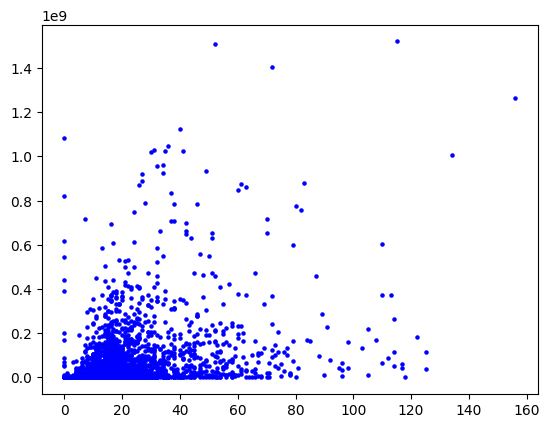

In [18]:
print('----- cast_count VS revenue -----')
print('linear correlation:', train['cast_count'].corr(train['revenue']))
print('mutual dependency:', mutual_info_regression(train[['cast_count']], train['revenue'])[0])
plt.scatter(train['cast_count'], train['revenue'], color='blue', s=5)

In [19]:
train["cast_list"] = train["cast"].map(lambda x: [f'cast_{cast["name"]}' for cast in ast.literal_eval(x)] if pd.notna(x) else [])
test["cast_list"] = test["cast"].map(lambda x: [f'cast_{cast["name"]}' for cast in ast.literal_eval(x)] if pd.notna(x) else [])

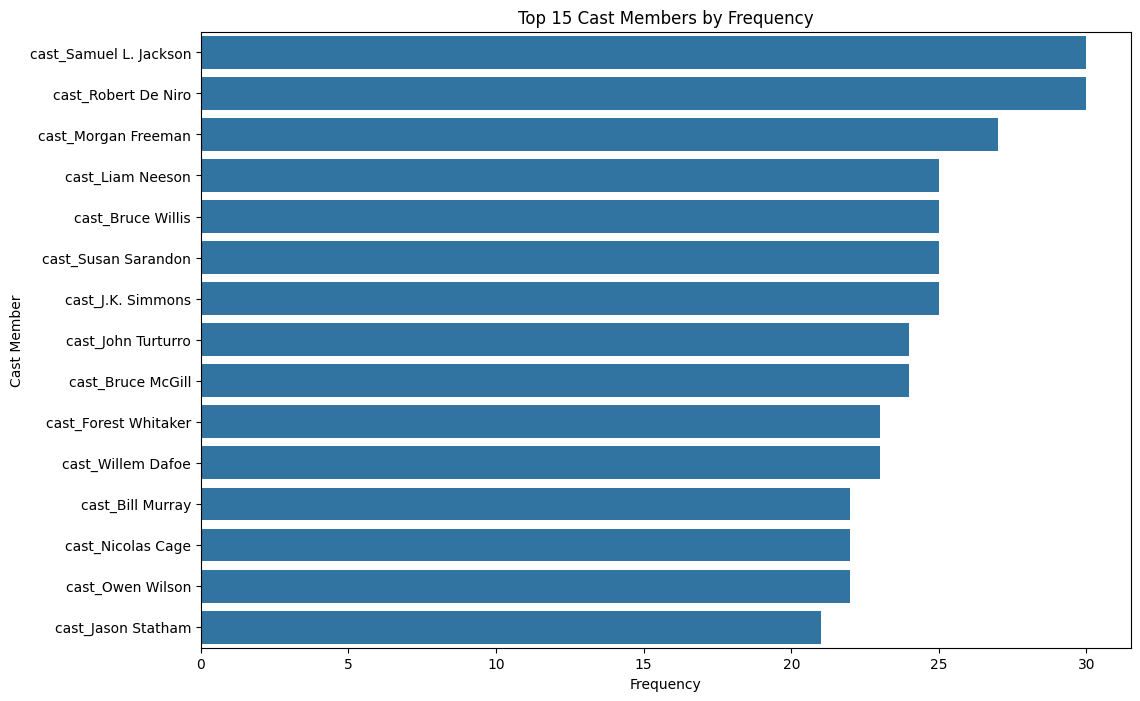

In [20]:
all_cast = [actor for sublist in train['cast_list'] for actor in sublist]
cast_counter = Counter(all_cast)
cast_df = pd.DataFrame(cast_counter.items(), columns=['Cast Member', 'Frequency'])
cast_df = cast_df.sort_values(by='Frequency', ascending=False)

top_N = 15
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Cast Member', data=cast_df.head(top_N))
plt.title(f'Top {top_N} Cast Members by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Cast Member')
plt.show()

In [21]:
all_cast = [actor for sublist in train['cast_list'] for actor in sublist]
cast_counter = Counter(all_cast)
top_cast_names = [name for name, count in cast_counter.most_common(15)]

train["cast_list_filtered"] = train["cast_list"].apply(lambda x: [cast for cast in x if cast in top_cast_names])
test["cast_list_filtered"] = test["cast_list"].apply(lambda x: [cast for cast in x if cast in top_cast_names])

mlb = MultiLabelBinarizer(classes=top_cast_names)

train_cast_encoded = mlb.fit_transform(train["cast_list_filtered"])
test_cast_encoded = mlb.transform(test["cast_list_filtered"])

train_cast_encoded_df = pd.DataFrame(train_cast_encoded, columns=mlb.classes_)
test_cast_encoded_df = pd.DataFrame(test_cast_encoded, columns=mlb.classes_)

train = pd.concat([train, train_cast_encoded_df], axis=1)
test = pd.concat([test, test_cast_encoded_df], axis=1)

train.drop(columns=["cast_list", "cast_list_filtered"], inplace=True)
test.drop(columns=["cast_list", "cast_list_filtered"], inplace=True)

In [22]:
train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 0]) if pd.notna(x) else 0)
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 1]) if pd.notna(x) else 0)
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 2]) if pd.notna(x) else 0)

test['genders_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 0]) if pd.notna(x) else 0)
test['genders_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 1]) if pd.notna(x) else 0)
test['genders_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in ast.literal_eval(x) if i['gender'] == 2]) if pd.notna(x) else 0)

In [23]:
train.drop(columns=['cast'], inplace=True)
test.drop(columns=['cast'], inplace=True)

### status

In [24]:
train['status'].value_counts()

status
Released    2996
Rumored        4
Name: count, dtype: int64

In [25]:
train.loc[train['status'] == 'Rumored'][['status','revenue','cast_count','crew_count']]

,status,revenue,cast_count,crew_count
609,Rumored,273644,4,3
1007,Rumored,60,1,8
1216,Rumored,13418091,13,16
1618,Rumored,229000,1,1


In [26]:
train['status'] = train['status'].apply(lambda x: 1 if x == 'Released' else 0)
test['status'] = test['status'].apply(lambda x: 1 if x == 'Released' else 0)

### production_countries

In [27]:
for i, e in enumerate(train['production_countries'][30:35]):
  print(i, e)

0 [{'iso_3166_1': 'FR', 'name': 'France'}]
1 [{'iso_3166_1': 'AT', 'name': 'Austria'}, {'iso_3166_1': 'FR', 'name': 'France'}, {'iso_3166_1': 'DE', 'name': 'Germany'}, {'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'NZ', 'name': 'New Zealand'}, {'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso_3166_1': 'IL', 'name': 'Israel'}, {'iso_3166_1': 'JP', 'name': 'Japan'}]
4 [{'iso_3166_1': 'US', 'name': 'United States of America'}]


In [28]:
train['count_production_countries'] = train['production_countries'].map(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)
test['count_production_countries'] = test['production_countries'].map(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)

----- count_production_countries VS revenue -----
linear correlation: 0.052954906051833825
mutual dependency: 0.019027778422563868


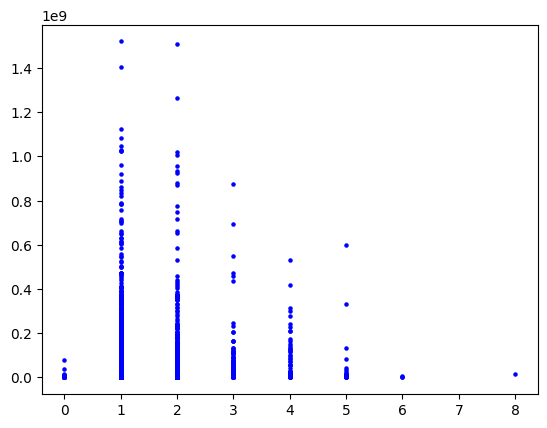

In [29]:
print('----- count_production_countries VS revenue -----')
print('linear correlation:', train['count_production_countries'].corr(train['revenue']))
print('mutual dependency:', mutual_info_regression(train[['count_production_countries']], train['revenue'])[0])
plt.scatter(train['count_production_countries'], train['revenue'], color='blue', s=5)

In [30]:
train["production_countries_list"] = train["production_countries"].map(lambda x: [f'country_{country["iso_3166_1"]}' for country in ast.literal_eval(x)] if pd.notna(x) else [])
test["production_countries_list"] = test["production_countries"].map(lambda x: [f'country_{country["iso_3166_1"]}' for country in ast.literal_eval(x)] if pd.notna(x) else [])

In [31]:
train["production_countries_list"].value_counts()[0:10]

production_countries_list
[country_US]                1752
[country_GB, country_US]     118
[country_GB]                  94
[country_IN]                  69
[]                            55
[country_FR]                  51
[country_CA, country_US]      48
[country_DE, country_US]      47
[country_RU]                  46
[country_JP]                  31
Name: count, dtype: int64

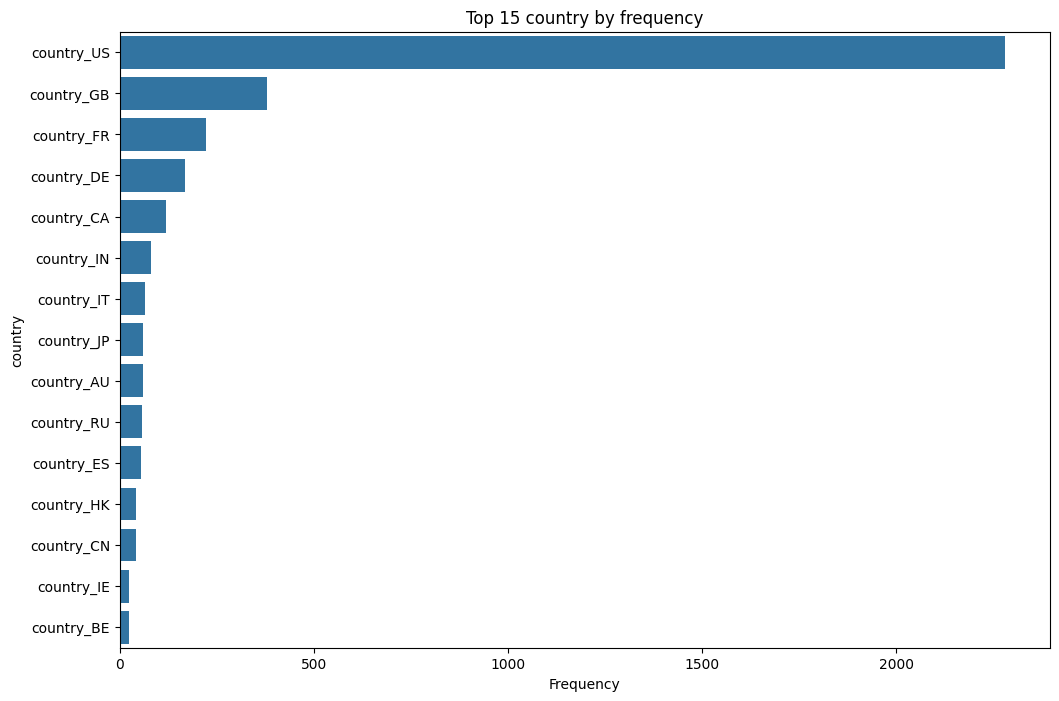

In [32]:
all_countries = [country for sublist in train['production_countries_list'] for country in sublist]
counter = Counter(all_countries)
cast_df = pd.DataFrame(counter.items(), columns=['country', 'Frequency'])
cast_df = cast_df.sort_values(by='Frequency', ascending=False)

top_N = 15
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='country', data=cast_df.head(top_N))
plt.title(f'Top {top_N} country by frequency')
plt.xlabel('Frequency')
plt.ylabel('country')
plt.show()

In [33]:
all_countries = [country for sublist in train['production_countries_list'] for country in sublist]
counter = Counter(all_countries)
top_countries = [name for name, count in counter.most_common(15)]

train["production_countries_list_filtered"] = train["production_countries_list"].apply(lambda x: [country for country in x if country in top_countries])
test["production_countries_list_filtered"] = test["production_countries_list"].apply(lambda x: [country for country in x if country in top_countries])

mlb = MultiLabelBinarizer(classes=top_countries)

train_countries_encoded = mlb.fit_transform(train["production_countries_list_filtered"])
test_countries_encoded = mlb.transform(test["production_countries_list_filtered"])

train_countries_encoded_df = pd.DataFrame(train_countries_encoded, columns=mlb.classes_)
test_countries_encoded_df = pd.DataFrame(test_countries_encoded, columns=mlb.classes_)

train = pd.concat([train, train_countries_encoded_df], axis=1)
test = pd.concat([test, test_countries_encoded_df], axis=1)

train.drop(columns=["production_countries_list", "production_countries_list_filtered"], inplace=True)
test.drop(columns=["production_countries_list", "production_countries_list_filtered"], inplace=True)

In [34]:
train.drop(columns=['production_countries'], inplace=True)
test.drop(columns=['production_countries'], inplace=True)

In [35]:
train

,production_companies,status,revenue,crew_count,crew_Casting_Avy Kaufman,crew_Casting_Deborah Aquila,crew_Original Music Composer_James Newton Howard,crew_Original Music Composer_Jerry Goldsmith,crew_Casting_Mary Vernieu,crew_Casting_Francine Maisler,...,country_IN,country_IT,country_JP,country_AU,country_RU,country_ES,country_CN,country_HK,country_IE,country_BE
0,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",1,12314651,72,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[{'name': 'Walt Disney Pictures', 'id': 2}]",1,95149435,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...",1,13092000,64,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,1,16000000,3,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,NaN,1,3923970,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",1,1596687,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2996,"[{'name': 'Memfis Film', 'id': 321}, {'name': ...",1,180590,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2997,"[{'name': 'New Line Cinema', 'id': 12}, {'name...",1,89456761,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2998,"[{'name': 'Jersey Films', 'id': 216}, {'name':...",1,171963386,89,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### production_companies

In [36]:
for i, e in enumerate(train['production_companies'][:5]):
  print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 nan
4 nan


In [37]:
train['production_companies_count'] = train['production_companies'].map(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)
test['production_companies_count'] = test['production_companies'].map(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)

----- production_companies_count VS revenue -----
linear correlation: 0.15569953980317405
mutual dependency: 0.06117544266325314


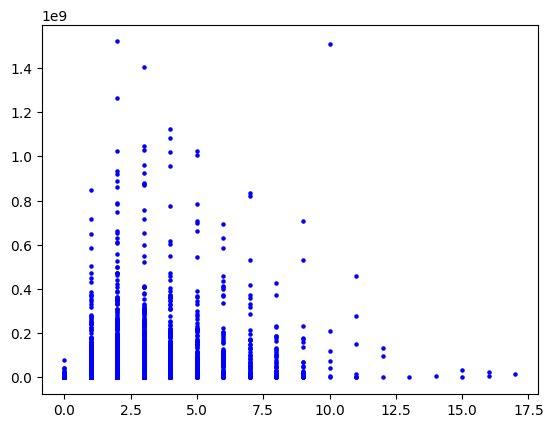

In [38]:
print('----- production_companies_count VS revenue -----')
print('linear correlation:', train['production_companies_count'].corr(train['revenue']))
print('mutual dependency:', mutual_info_regression(train[['production_companies_count']], train['revenue'])[0])
plt.scatter(train['production_companies_count'], train['revenue'], color='blue', s=5)

In [39]:
train["company_list"] = train["production_companies"].map(lambda x: [f'company_{company["name"]}' for company in ast.literal_eval(x)] if pd.notna(x) else [])
test["company_list"] = test["production_companies"].map(lambda x: [f'companyt_{company["name"]}' for company in ast.literal_eval(x)] if pd.notna(x) else [])

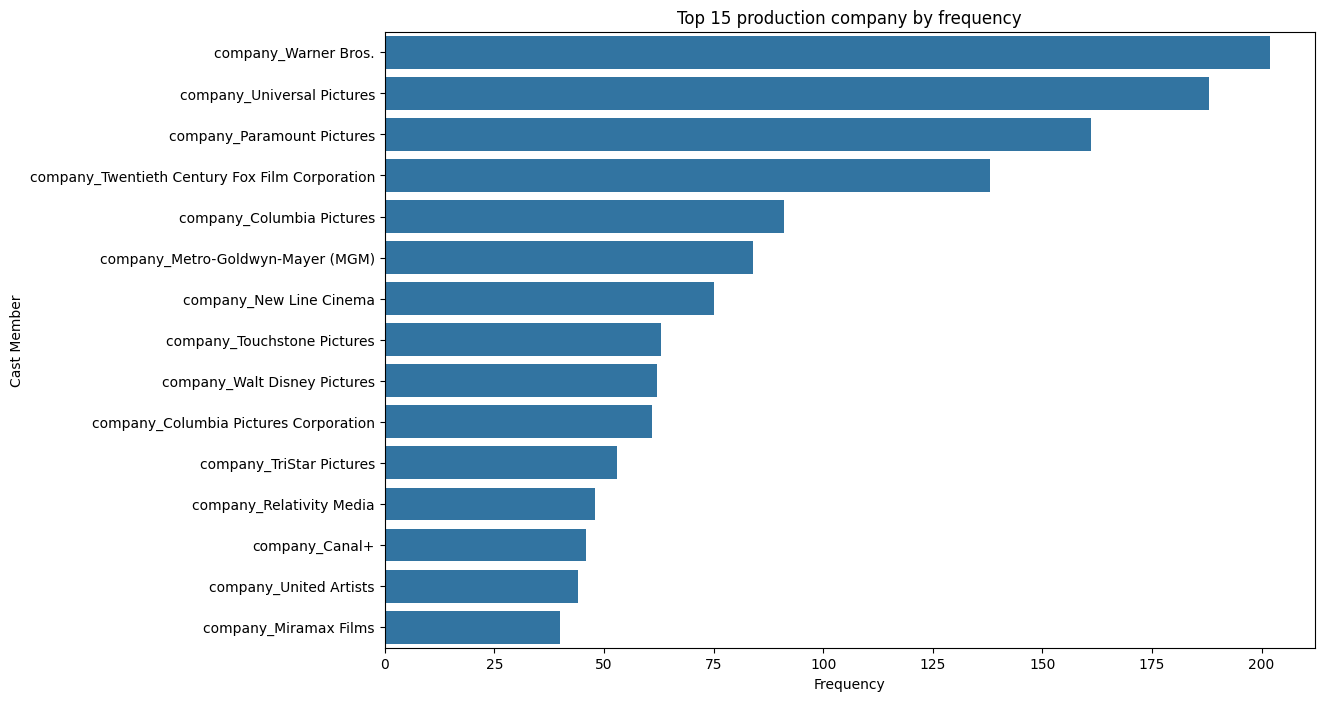

In [40]:
all_company = [company for sublist in train['company_list'] for company in sublist]
counter = Counter(all_company)
cast_df = pd.DataFrame(counter.items(), columns=['company', 'Frequency'])
cast_df = cast_df.sort_values(by='Frequency', ascending=False)

top_N = 15
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='company', data=cast_df.head(top_N))
plt.title(f'Top {top_N} production company by frequency')
plt.xlabel('Frequency')
plt.ylabel('Cast Member')
plt.show()

In [41]:
all_company = [company for sublist in train['company_list'] for company in sublist]
counter = Counter(all_company)
top_companies = [name for name, count in counter.most_common(15)]

train["company_list_filtered"] = train["company_list"].apply(lambda x: [company for company in x if company in top_companies])
test["company_list_filtered"] = test["company_list"].apply(lambda x: [company for company in x if company in top_companies])

mlb = MultiLabelBinarizer(classes=top_companies)

train_companies_encoded = mlb.fit_transform(train["company_list_filtered"])
test_companies_encoded = mlb.transform(test["company_list_filtered"])

train_companies_encoded_df = pd.DataFrame(train_companies_encoded, columns=mlb.classes_)
test_companies_encoded_df = pd.DataFrame(test_companies_encoded, columns=mlb.classes_)

train = pd.concat([train, train_companies_encoded_df], axis=1)
test = pd.concat([test, test_companies_encoded_df], axis=1)

train.drop(columns=["company_list", "company_list_filtered"], inplace=True)
test.drop(columns=["company_list", "company_list_filtered"], inplace=True)

In [42]:
train.drop(columns=['production_companies'], inplace=True)
test.drop(columns=['production_companies'], inplace=True)

## check

In [45]:
train.columns

Index(['status', 'revenue', 'crew_count', 'crew_Casting_Avy Kaufman',
       'crew_Casting_Deborah Aquila',
       'crew_Original Music Composer_James Newton Howard',
       'crew_Original Music Composer_Jerry Goldsmith',
       'crew_Casting_Mary Vernieu', 'crew_Casting_Francine Maisler',
       'crew_Casting_Tricia Wood', 'crew_Original Music Composer_James Horner',
       'crew_Casting_Kerry Barden', 'crew_Casting_Janet Hirshenson',
       'crew_Casting_Jane Jenkins', 'crew_Casting_John Papsidera',
       'crew_Casting_Billy Hopkins', 'crew_Executive Producer_Bob Weinstein',
       'crew_Executive Producer_Harvey Weinstein',
       'crew_Producer_Neal H. Moritz', 'crew_Casting_Mindy Marin',
       'crew_Original Music Composer_Hans Zimmer', 'crew_Foley_Dan O'Connell',
       'crew_Casting_Suzanne Smith', 'crew_Casting_Sarah Finn',
       'crew_Casting_Amanda Mackey',
       'crew_Original Music Composer_Danny Elfman',
       'crew_Executive Producer_Bruce Berman', 'crew_Casting_Deni

In [44]:
train.head()

,status,revenue,crew_count,crew_Casting_Avy Kaufman,crew_Casting_Deborah Aquila,crew_Original Music Composer_James Newton Howard,crew_Original Music Composer_Jerry Goldsmith,crew_Casting_Mary Vernieu,crew_Casting_Francine Maisler,crew_Casting_Tricia Wood,...,company_Metro-Goldwyn-Mayer (MGM),company_New Line Cinema,company_Touchstone Pictures,company_Walt Disney Pictures,company_Columbia Pictures Corporation,company_TriStar Pictures,company_Relativity Media,company_Canal+,company_United Artists,company_Miramax Films
0,1,12314651,72,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,95149435,9,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,13092000,64,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,16000000,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,3923970,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
train.shape, test.shape

((3000, 87), (4398, 86))